In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/pneumoniadetection/chest_xray_2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

###

In [ ]:
# import các thư viện cần thiết khác
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # reshaping images to prefered size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [ ]:
# for listing data and directory
!ls gdrive/MyDrive/pneumoniadetection/chest_xray_2/train

NORMAL	PNEUMONIA


In [ ]:
### Loading data
train = get_training_data('gdrive/MyDrive/pneumoniadetection/chest_xray_2/train')
test = get_training_data('gdrive/MyDrive/pneumoniadetection/chest_xray_2/test')
val = get_training_data('gdrive/MyDrive/pneumoniadetection/chest_xray_2/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-4-a23b4e85f610>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



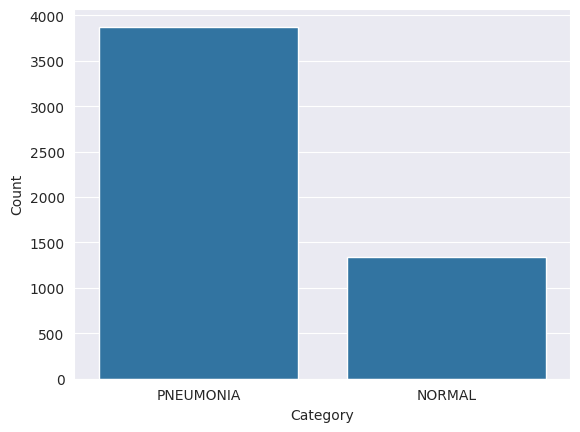

In [ ]:
from collections import Counter
### Data visualization and Preprocessing
l = []
for i in train:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")
sns.set_style('darkgrid')

counter = Counter(l)
data = {"Category": list(counter.keys()), "Count": list(counter.values())}
df = pd.DataFrame(data)
sns.barplot(x="Category", y="Count", data=df)
plt.show()

Text(0.5, 1.0, 'NORMAL')

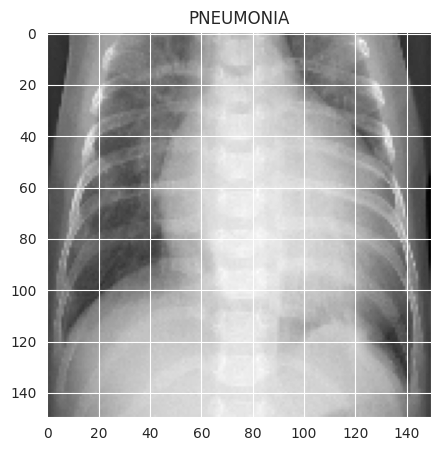

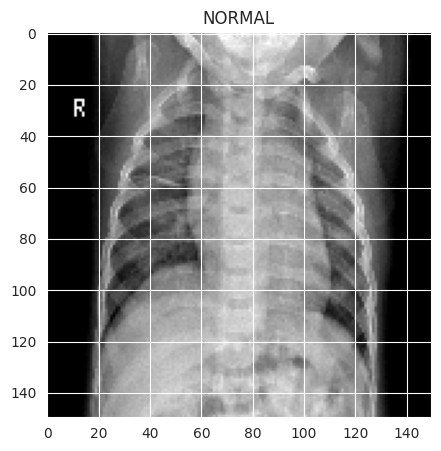

In [ ]:
# Nhận thấy dữ liệu không cân bằng, thực hiện tăng số samples normal lên để sử dụng data augmentation
# Xem lại hình ảnh của cả 2 class
plt.figure(figsize=(5,5))
plt.imshow(train[0][0],cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
# splitting data
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# thực hiện grayscale normalization để giảm sự khác biệt độ sáng (hạn chế effect của illumination khác nhau trên mỗi ảnh)
# ngoài ra thì CNN hội tụ (converges) nhanh hơn trong đoạn [0,1] so với đoạn [0,255]
# normalize data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
### Data Augmentation (tăng cường dữ liệu)
# để hạn chế việc bị overfitting, cần mở rộng giả cho tập dữ liệu (expending artificially the dataset)
# ý tưởng là mở rộng tập dữ liệu bằng cách sử dụng một số biến đổi nhỏ để tái tạo các biến thể (variantions)
# Việc áp dụng các phương pháp thay đổi dữ liệu huấn luyện bằng cách thay đổi cách biểu diễn mảng nhưng giữ nguyên nhãn (label) được gọi là kỹ thuật tăng dữ liệu Data Augmentation Techniques
# Một vài kỹ thuật tăng cường dữ liệu phổ biến bao gồm grayscales, horizontal flips lật ngang, vertical flips lật dọc, random crops, color jitters, translation biến dạng, rotations xoay,...
# Việc áp dụng các kĩ thuật biến đổi (transformation) cho tập dataset có thể giúp tăng gấp 2 hoặc 3 lần kích thước để tạo ra mô hình tốt hơn (a very robust model)

In [ ]:
# bằng việc sử dụng kỹ thuật data augmentation có thể hạn chế overfitting và kiểm soát mất cân bằng dữ liệu (imbalance dataset)
datagen = ImageDataGenerator(
#    featurewise_center = False, # set each mean to 0 over dataset
#    samplewise_center=False, # set each sample mean to 0
#    featurewise_std_normalization=False, # divide inputs by std of the dataset
#    samplewise_std_normalization=False, # divide each input by its std
#    zca_whitening = False, # applying ZCA whitening
#    rotation_range = 30, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # randomly zoom image
#    width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip = True, # randomly flip images
#    vertical_flip=False # randomly flip images
)

datagen.fit(x_train)

In [ ]:
# Data Augmentation details
# 1. Randomly rotate some training images by 30 degrees
# 2. Randomly Zoom by 20% some training images
# 3. Randomly shift images horizontally by 10% of the width
# 4. Randomly shift images vertical by 10% of the height
# 5. Randomly flip images horizontally. --Once the model is ready, fit the training dataset

In [ ]:
#### Trainning model
# khởi tạo model
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 5 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/5
163/163 [==============================] - 359s 2s/step - loss: 0.5854 - accuracy: 0.8587 - val_loss: 19.5119 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
163/163 [==============================] - 360s 2s/step - loss: 0.2350 - accuracy: 0.9156 - val_loss: 41.6707 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
163/163 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9367
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 357s 2s/step - loss: 0.1850 - accuracy: 0.9367 - val_loss: 55.3070 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
163/163 [==============================] - 360s 2s/step - loss: 0.1330 - accuracy: 0.9544 - val_loss: 2.3873 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/5
163/163 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9628
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==============================] 

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 12s 573ms/step - loss: 5.0427 - accuracy: 0.6907
Loss of the model is -  5.042744159698486
20/20 [==============================] - 11s 568ms/step - loss: 5.0427 - accuracy: 0.6907
Accuracy of the model is -  69.07051205635071 %


In [ ]:
model.save('/gdrive/MyDrive/pneumoniadetection/cnn_92accuracy_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls /gdrive/MyDrive/pneumoniadetection/

cnn_92accuracy_model.h5


In [ ]:
## Code lỗi
#result = model.evaluate(x_test, y_test)
#print("Type of result:", type(result))
# Kiểm tra giá trị trả về
#print("Result:", result)
#print("--------------")
#print("Loss of the model is - ", result)
# print("Accuracy  of the model is - ", model.evaluate(x_test,y_test)[1] * 100 , "%.")
#print("Accuracy of the model is - ", result[1] * 100, "%.")

In [ ]:
### Analysis after Model Training

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


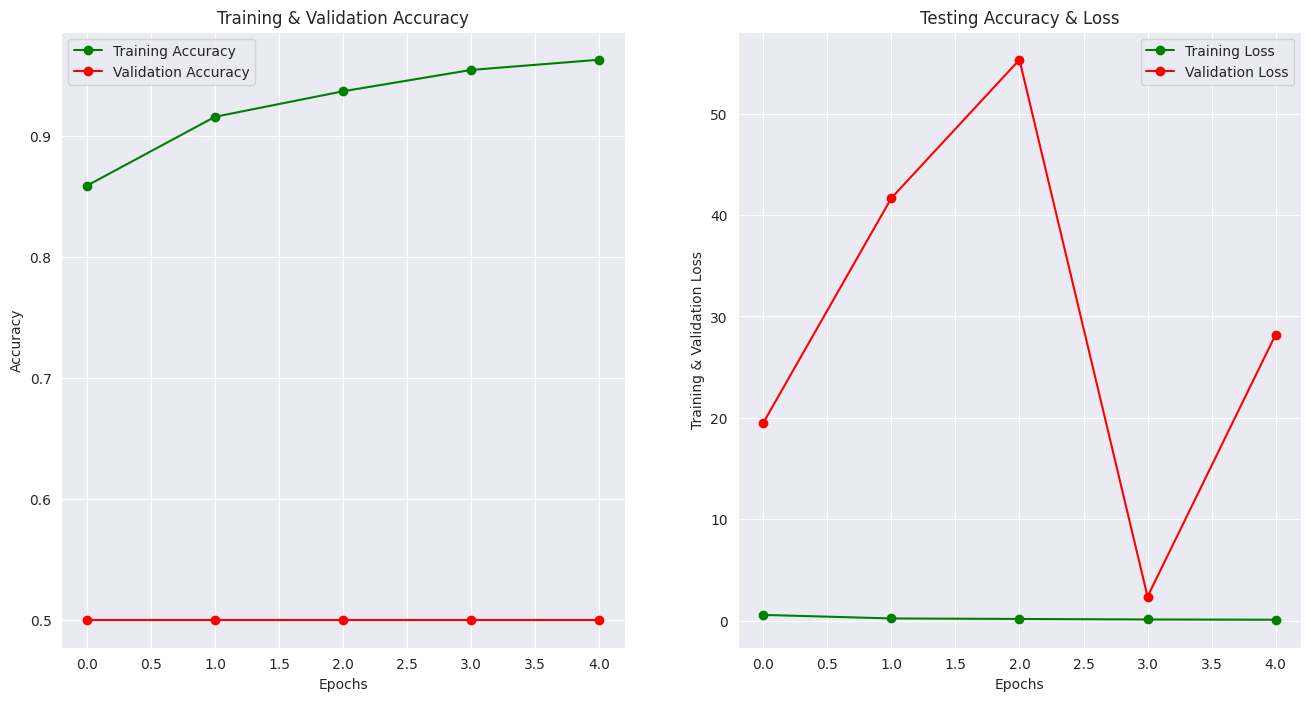

In [ ]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,8)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
## Code lỗi
"""
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
h_learningrate = history.history['lr']
h_loss = history.history['loss']
h_valloss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , h_loss , 'go-' , label = 'Loss')
ax[0].plot(epochs , h_valloss , 'ro-' , label = 'Validation Loss')
ax[0].set_title('Loss & Valadation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , h_loss , 'g-o' , label = 'Loss')
ax[1].plot(epochs , h_learningrate , 'r-o' , label = 'LearningRate')
ax[1].set_title('Loss & Learning Rate')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss & Learnong Rate")
plt.show()
"""

'\nepochs = [i for i in range(50)]\nfig , ax = plt.subplots(1,2)\nh_learningrate = history.history[\'lr\']\nh_loss = history.history[\'loss\']\nh_valloss = history.history[\'val_loss\']\nfig.set_size_inches(20,10)\n\nax[0].plot(epochs , h_loss , \'go-\' , label = \'Loss\')\nax[0].plot(epochs , h_valloss , \'ro-\' , label = \'Validation Loss\')\nax[0].set_title(\'Loss & Valadation Loss\')\nax[0].legend()\nax[0].set_xlabel("Epochs")\nax[0].set_ylabel("Loss")\n\nax[1].plot(epochs , h_loss , \'g-o\' , label = \'Loss\')\nax[1].plot(epochs , h_learningrate , \'r-o\' , label = \'LearningRate\')\nax[1].set_title(\'Loss & Learning Rate\')\nax[1].legend()\nax[1].set_xlabel("Epochs")\nax[1].set_ylabel("Loss & Learnong Rate")\nplt.show()\n'

In [ ]:
#predictions = model.predict_classes(x_test)
#predictions = predictions.reshape(1,-1)[0]
#predictions[:15]

predictions_probs = model.predict(x_test)
predictions = np.argmax(predictions_probs, axis=-1)
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

20/20 [==============================] - 11s 541ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# some of the correctly predicted classes

<ipython-input-27-3b0e8ec19e68>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


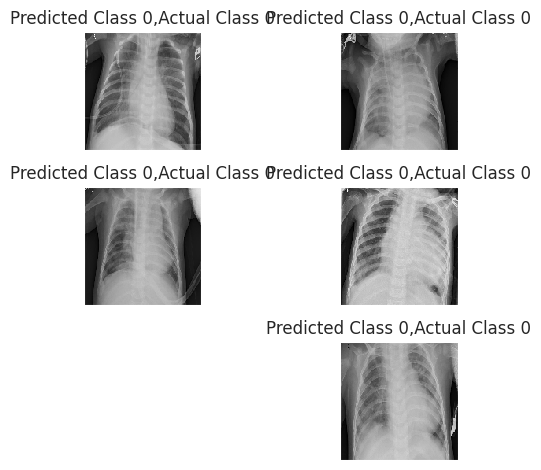

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# some of the incorrectly predicted class

<ipython-input-28-d863d2b73908>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


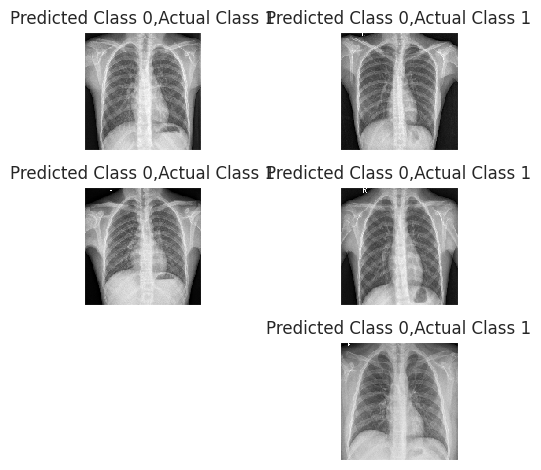

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1